### 1. [영상 인식] 다음 코드를 무엇을 의미하는지 이해하고 실행하여 결과를 확인하세요. (7점) (코드의 해석과 결과의 의미를 작성하세요.)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

is_cuda=False
if torch.cuda.is_available():
    is_cuda = True
    
transformation = transforms.Compose([transforms.ToTensor(), # 이미지 데이터를 텐서로 변경
                                     transforms.Normalize((0.1307,), (0.3081,))]) # 이미지를 정규화

train_dataset = datasets.MNIST('data/',train=True,
                               transform=transformation,download=True)
test_dataset = datasets.MNIST('data/',train=False,
                              transform=transformation,download=True)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=32,shuffle=True)

sample_data = next(iter(train_loader))

def plot_img(image):
    image = image.numpy()[0]
    mean = 0.1307
    std = 0.3081
    image = ((mean * image) + std)
    plt.imshow(image,cmap='gray')



C:\Users\zyunhyeok\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#### (1) 화면 출력 확인

plot_img 함수에서 이미지를 입력으로 받으면 해당 이미지의 0번째 배열을 가져와서 정규분포화 한 후에 그림을 보여주게 설정한다.

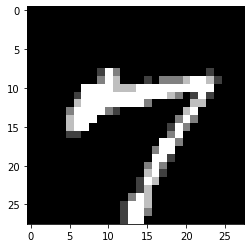

In [2]:
plot_img(sample_data[0][2])

#### (2) 화면 출력 확인

plot_img 함수에서 이미지를 입력으로 받으면 해당 이미지의 0번째 배열을 가져와서 정규분포화 한 후에 그림을 보여주게 설정한다.

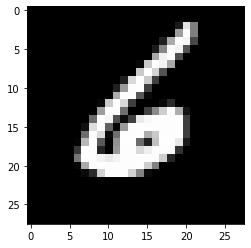

In [3]:
plot_img(sample_data[0][1])

In [4]:
class Net(nn.Module):
    def __init__(self ):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x,p=0.1, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

model = Net()
if is_cuda:
    model.cuda()
    
optimizer = optim.SGD(model.parameters(),lr=0.01)

data , target = next(iter(train_loader))

output = model(Variable(data.cuda()))


#### (3) output.size() 출력 확인

output은 각 10개의 숫자에 대한 확률값이 출력되기 때문에 [32,10]으로 사이즈가 표현된다.  
즉, 32개의 샘플에 대한 0~9까지의 숫자의 각각에 대한 확률값을 표현한다.

In [5]:
print(output.size())

torch.Size([32, 10])


#### (4) target.size() 출력 확인

target은 정답인 1개의 값을 표현하기 때문에 sample의 갯수와 동일한 크기의 [32]만 출력된다.  
즉, 32개의 샘플에 대한 정답값만을 표현한다.

In [6]:
print(target.size())

torch.Size([32])


#### (5) 화면 출력 확인

학습이 잘 이루어지는 것을 확인할 수 있다.

In [7]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)

        running_loss += F.nll_loss(output,target,size_average=False).data
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()

    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)

    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss, accuracy

train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]

for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

    

C:\Users\zyunhyeok\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is  0.68 and training accuracy is 47260/60000     78.77
validation loss is  0.18 and validation accuracy is 9460/10000      94.6
training loss is  0.22 and training accuracy is 56230/60000     93.72
validation loss is   0.1 and validation accuracy is 9692/10000     96.92
training loss is  0.16 and training accuracy is 57194/60000     95.32
validation loss is 0.073 and validation accuracy is 9775/10000     97.75
training loss is  0.13 and training accuracy is 57720/60000      96.2
validation loss is 0.061 and validation accuracy is 9814/10000     98.14
training loss is  0.11 and training accuracy is 57989/60000     96.65
validation loss is 0.052 and validation accuracy is 9832/10000     98.32
training loss is   0.1 and training accuracy is 58123/60000     96.87
validation loss is  0.05 and validation accuracy is 9834/10000     98.34
training loss is 0.092 and training accuracy is 58382/60000      97.3
validation loss is 0.045 and validation accuracy is 9850/10000      98.5

#### (6) 화면 출력 확인

training loss와 validation loss 모두 감소하는 것을 확인할 수 있다.

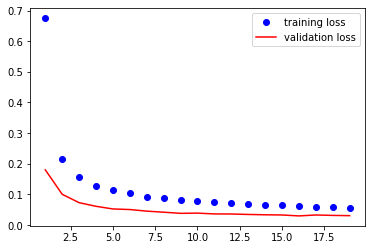

In [8]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

#### (7) 화면 출력 확인

train accuracy와 val accuracy 모두 증가하는 것을 확인할 수 있다.

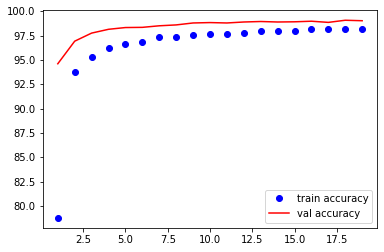

In [9]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()

### 2. [CNN] 다음 코드를 무엇을 의미하는지 이해하고 실행하여 결과를 확인하세요. (7점) (코드의 해석과 결과의 의미를 작성하세요.)

torch.nn 패키지를 사용하여 신경망을 생성함.  
nn 패키지는 모델을 정의할 때, autograd를 통해 자동미분 기능을 제공함  
nn.Module은 층과 전방전파 forward propagation (입력→출력)을 쉽게 구현함  
참고로 nn패키지는 mini-batch만 지원함, 예로 nn.Covn2d는4차Tensor를받음(nSamples * nChannels * height * width)  
아래 AlexNet (이미 수업에서 학습함.) 예시는 숫자를 분류하는 간단한 컨볼루션 신경망의 예임  
예시는 사진 입력을 받고, 몇 개의 층에 전방 전파하면서 분류를 출력함  
출력을 위해서 모델은 다음과 같은 학습을 수행함  
신경망은 학습 가능한 매개변수들 (가중치들)을 가짐  
사진 데이터를 반복적으로 입력함  
신경망을 통해 입력을 처리함 (전방 전파)  
손실 (오차)를 계산함 (실제 출력과 예측 출력을 비교하여 학습의 올바름을 판단함)  
오차로부터 그레이디언트 (경사, 방향)을 신경망의 각 매개변수에게 역전파함 (오류 역전파)  
신경망의 매개변수들을 갱신함 ( (미래)가중치 = (현재)가중치 – 학습률 * 그레이디언트 )  
위의 컨볼루션 신경망의 부분들을 torch를 통해서 손쉽게 구현할 수 있음  
단지 forward 함수만 정의하면,autograd를 이용해 해당연산 그래프의 그레이디언트를 구하는 backward 자동적으로 정의됨  
forward 함수는 Tensor를 이용할 수 있는 다양한 연산들 (합, 곱 등등) 사용하여 정의 가능함  
torch.Tensor: 자동 미분 기능을 지원하는 다차원 배열, 각 Tensor에 해당하는 그레이디언트를 가짐  
nn.Module: 신경망 모듈이며 매개변수의 캡슐화, GPU 연산 등 작업을 쉽게 가능하게 함  
nn.Parameter: 모듈이 지정되면 매개변수들을 자동으로 관리하는 Tensor의 하나임  


#### (1) 화면 출력 확인 및 의미를 서술

Net을 통해 conv layer와 fc layer를 정의한다.  
conv layer는 conv1, conv2를 통해 2개의 컨볼루션 층으로 구성되어있다.  
conv1은 1개의 input channel을 받아서 6개의 output channel를 출력하고, 5X5 필터를 사용한다.  
conv2은 6개의 input channel을 받아서 16개의 output channel를 출력하고, 5X5 필터를 사용한다.  
fc layer는 fc1, fc2, fc3를 통해 3개의 완전연결층으로 구성되어있다.  

forward를 통해 신경망을 통과시킨다.  
conv1 -> relu -> maxpool -> conv2 -> relu -> maxpool -> flatten -> fc1 -> fc2 -> fc3 순서대로 진행한다.  

num_flat_features는 배치를 제외한 모든 차원을 곱해서 전체 feature를 구하는 함수를 정의했다.  

print(Net)을 통해 정의한 신경망을 출력한다.  

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self ):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


#### (2) 정의된 컨볼루션 신경망의 구조 설명 (위의 AlexNet 그림 참고)

총 2개의 conv layer와 3개의 fully connected layer로 구성된다.    
conv layer 이후 activation function으로는 ReLU를 사용하고, 그 후 (2,2) kernel_size로 maxpooling을 수행한다.  
신경망은 conv - ReLU - pool 순서로 진행된다.

#### (3) 화면 출력 확인

net.paramters()를 사용하여 정의된 신경망의 학습 가능한 매개변수들을 확인할 수 있다.
params[0].size()는 conv1의 가중치를 의미한다.

In [11]:
# net.parameters()를 사용하여 정의된 신경망의 학습가능한 매개변수들을 확인할 수 있음
params = list(net.parameters())
print(len(params))
print(params[0].size()) # conv1's .weight

10
torch.Size([6, 1, 5, 5])


#### (4) 화면 출력 확인

임의의 크기로 1 * 32 * 32의 입력값을 받았을 때의 결과 값이다.

In [12]:
# 다음의 임의의 32*32 입력을 가정함
# 참고로 크기가 다른 입력을 받을 때는 입력의 크기를 재조정하거나 신경망 수정함
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.0379,  0.0248, -0.0229,  0.0262,  0.0759,  0.0648, -0.0310, -0.0323,
         -0.0467, -0.1021]], grad_fn=<AddmmBackward>)


#### (5) 화면 출력 확인

zero_grad()를 사용해서 그레디언트를 초기화한 후 역전파를 진행한다.  
target과 비교해서 MSELoss를 구한 결과를 출력한 결과이다.

In [13]:
# 오류역전파를 통해 그레이디언트를 구하기 전에 모든 가중치의 그레이디언트 버퍼들을 초기화
net.zero_grad()
out.backward(torch.randn(1, 10))

# 손실 함수 정의 및 임의의 값들에 대해서 오차 결과 확인
# nn 패키지는 많이 사용되는 손실함수들을 제공하며, 해당 예제는 단순한 MSE를 사용
output = net(input)
target = torch.randn(10) # a dummy target, for example
target = target.view(1, -1) # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)


tensor(1.0556, grad_fn=<MseLossBackward>)


#### (6) 화면 출력 확인

그레디언트를 0으로 초기화한 후 backward 이전의 bias에 대한 그레디언트를 확인한 결과 모두 0값을 가진다.

In [14]:
# 앞에 코드에서 언급한 것과 같이 오류 역전파하기 전, 그레이디언트를 초기화해야 함
# backward() 수행 후 어떤 변화가 있는지 확인하고, 초기화의 필요성을 확인함
net.zero_grad() # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])


#### (7) 화면 출력 확인

backward()를 진행한 후의 그레디언트 값을 출력하였다.

In [15]:
loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad after backward
tensor([ 0.0015, -0.0061, -0.0087, -0.0024, -0.0052, -0.0078])


In [16]:
# 스토캐스틱경사하강법( (미래)가중치= (현재)가중치–학습률*그레이디언트)을이용하여가중치갱신하는코드는다음과같음
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)
    
# 하지만 위 구현 코드보다 실제, torch.optim에서 구현되는 SDG, Adam, RMSProp 등을 사용함
# 오류 역전파에서 최적화하는 방법을 보인 예제 코드
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad() # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step() # Does the update


### 3. [분류기 학습] 다음 코드를 무엇을 의미하는지 이해하고 실행하여 결과를 확인하세요. (7점) (코드의 해석과 결과의 의미를 작성하세요.)

1번의 기초적인 신경망을 통해서 사진 분류기를 학습함  
데이터집합은 CIFAR-10이며, 아래의 예와 같이 10가지의 3 (R, G, B)채널의 32*32 크기의 사진으로 구성됨  
CIFAR-10과 같이 많이 사용되는 데이터집합은 torchvision 패키지에서 제공함  
분류기 학습은 다음과 같은 과정을 가짐  
1. 정규화된 CIFAR-10 훈련집합과 테스트집합을 torchvision을 이용하여 적재함  
2. 컨볼루션 신경망을 정의함  
3. 손실함수 정의  
4. 훈련집합을 이용하여 신경망을 학습시킴  
5. 테스트집합을 이용하여 신경망 성능 확인

#### (1) 화면 출력 확인

정규화된 CIFAR-10 훈련집합과 테스트집합을 torchvision을 이용하여 적재하였다.  

In [17]:
### 1. 정규화된 CIFAR-10 훈련집합과 테스트집합을 torchvision을 이용하여 적재함

import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### (2) 화면 출력 확인

훈련집합의 일부 사진들 확인하였다.

 frog   cat  deer  frog


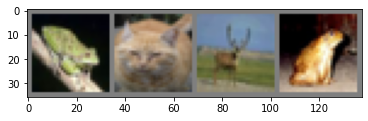

In [18]:
# 훈련집합의 일부 사진들 확인
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[ j]] for j in range(4)))

#### (3) 화면 출력 확인 및 학습이 되고 있는지 서술

loss가 점차 줄어드는 것을 확인할 수 있다.

In [19]:
### 2. 컨볼루션 신경망을 정의함

# 3채널 32*32 크기의 사진을 입력받고, 신경망을 통과해 10 부류를 수행
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self ):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

### 3. 손실함수 정의, 교차 엔트로피와 SGD+momentum

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. 훈련집합을 이용하여 신경망을 학습시킴

for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999: # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
            
print('Finished Training')


[1,  1000] loss: 2.262
[1,  2000] loss: 2.016
[1,  3000] loss: 1.863
[1,  4000] loss: 1.756
[1,  5000] loss: 1.620
[1,  6000] loss: 1.561
[1,  7000] loss: 1.535
[1,  8000] loss: 1.524
[1,  9000] loss: 1.491
[1, 10000] loss: 1.439
[1, 11000] loss: 1.428
[1, 12000] loss: 1.421
[2,  1000] loss: 1.362
[2,  2000] loss: 1.354
[2,  3000] loss: 1.356
[2,  4000] loss: 1.341
[2,  5000] loss: 1.326
[2,  6000] loss: 1.333
[2,  7000] loss: 1.296
[2,  8000] loss: 1.296
[2,  9000] loss: 1.266
[2, 10000] loss: 1.252
[2, 11000] loss: 1.288
[2, 12000] loss: 1.265
Finished Training


#### (4) 화면 출력 확인

testloader를 사용해서 정답 값 출력하였다.

GroundTruth:    cat  ship  ship plane


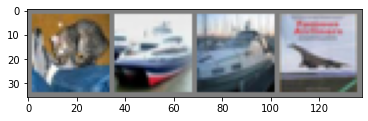

In [20]:
### 5. 테스트집합을 이용하여 신경망 성능 확인
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### (5) 화면 출력 확인

net.eval()을 사용한 학습한 모델에 대한 예측 값을 출력하였다.

In [21]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[ j]] for j in range(4)))

Predicted:   frog   car   car plane


#### (6) 화면 출력 확인 및 일반화 성능 서술

테스트 데이터를 사용한 정확도 출력하였다.

In [22]:
# performance on the whole test dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


Accuracy of the network on the 10000 test images: 54 %


#### (7) 화면 출력 확인 및 부류별 분류기의 성능 서술

각 클래스별 정답률을 출력하였다.  
frog의 분류성능이 65%로 가장 높았고, bird, cat의 분류성능이 29%로 가장 낮았다.

In [23]:
# performance on each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 74 %
Accuracy of  bird : 29 %
Accuracy of   cat : 29 %
Accuracy of  deer : 46 %
Accuracy of   dog : 50 %
Accuracy of  frog : 65 %
Accuracy of horse : 63 %
Accuracy of  ship : 63 %
Accuracy of truck : 71 %


### 4. 다음 링크의 TensorFlow tutorial의 사진 분류 과업을 수행하고, PyTorch와 간단하게 비교하세요. (7점)

https://www.tensorflow.org/tutorials/images/classification

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

#### TensorFlow 및 기타 라이브러리 가져오기

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#### 데이터세트 다운로드 및 탐색하기

In [3]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


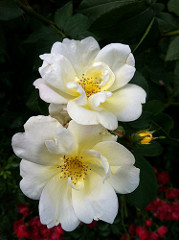

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

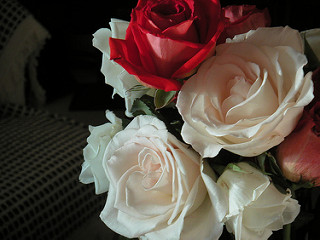

In [6]:
PIL.Image.open(str(roses[1]))

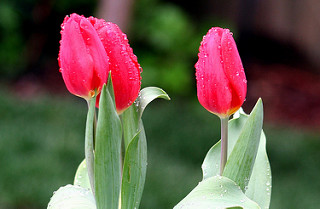

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

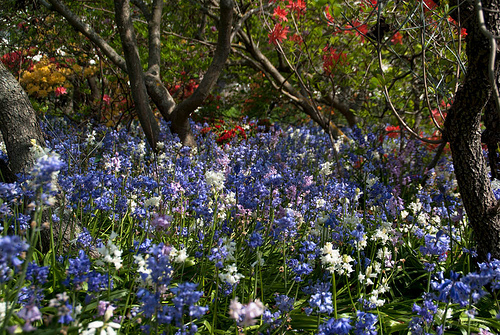

In [8]:
PIL.Image.open(str(tulips[1]))

#### keras.preprocessing을 사용하여 로드하기

#### 데이터세트 만들기

pytorch는 torchvision.datasets과 torch.utils.data.DataLoader를 통해 데이터를 불러옵니다.  
tensorflow는 tf.keras.preprocessing.image_dataset_from_directory을 통해 데이터를 불러옵니다.

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


#### 데이터 시각화하기

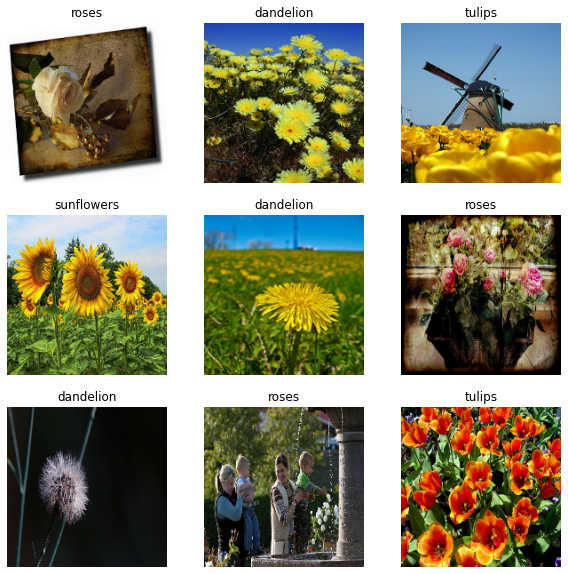

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


#### 성능을 높이도록 데이터세트 구성하기

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### 데이터 표준화하기

pytorch의 경우 transforms.Compose 내에서 transforms.ToTensor(),transforms.Normalize()를 통해 데이터를 표준화 및 정규화할 수 있다.  
tensorflow의 경우 layers.experimental.preprocessing.Rescaling를 통해 데이터를 표준화한다.

In [16]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.

print(np.min(first_image), np.max(first_image))

0.0 0.9407408


#### 모델 만들기

pytorch의 경우 Net 클래스를 생성하고, forward 함수로 신경망을 정의한다.  
tensorflow의 경우에는 tensorflow.keras.models.Sequential을 통해 모델을 만들 수 있고, add를 통한 추가가 가능하다.

In [18]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### 모델 컴파일하기

pytorch의 경우 critertion, optimizer을 지정하여 손실함수와 최적화 기법을 지정한다.  
tensorflow의 경우 model.compile을 통하여 최적화기법과 손실함수, 평가척도를 지정할 있다.

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### 모델 요약

pytorch의 경우 Net class를 변수로 지정하여 print를 통해 모델을 확인할 수 있다.  
tensorflow의 경우 model.summary()를 통해 모델을 확인할 수 있다.

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

#### 모델 훈련하기

pytorch는 반복문을 통하여 신경망을 학습한다.  
tensorflow의 경우는 model.fit()을 이용하여 학습을 진행할 수 있다.

In [21]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 34s 363ms/step - loss: 1.3404 - accuracy: 0.4138 - val_loss: 1.0921 - val_accuracy: 0.5422
Epoch 2/10
92/92 [==============================] - 32s 353ms/step - loss: 1.0464 - accuracy: 0.5838 - val_loss: 0.9873 - val_accuracy: 0.6022
Epoch 3/10
92/92 [==============================] - 32s 349ms/step - loss: 0.8941 - accuracy: 0.6550 - val_loss: 0.9174 - val_accuracy: 0.6485
Epoch 4/10
92/92 [==============================] - 32s 348ms/step - loss: 0.7178 - accuracy: 0.7319 - val_loss: 0.9554 - val_accuracy: 0.6512
Epoch 5/10
92/92 [==============================] - 32s 349ms/step - loss: 0.5221 - accuracy: 0.8093 - val_loss: 0.9765 - val_accuracy: 0.6362
Epoch 6/10
92/92 [==============================] - 32s 351ms/step - loss: 0.3501 - accuracy: 0.8767 - val_loss: 0.9995 - val_accuracy: 0.6512
Epoch 7/10
92/92 [==============================] - 32s 350ms/step - loss: 0.1956 - accuracy: 0.9360 - val_loss: 1.1871 - val_accuracy: 0.6608

#### 훈련 결과 시각화하기

pytorch의 경우는 별도로 변수를 설정하여 훈련 결과를 시각화 한다.  
tensorflow의 경우는 history 내의 변수를 이용하여 결과를 시각화 한다.

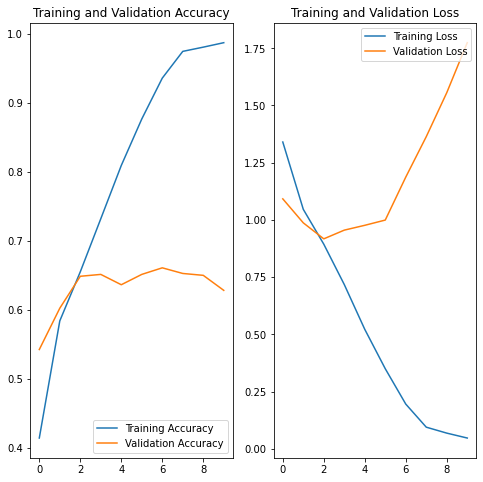

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 데이터 증강

pytorch는 transforms.Compose([])를 이용하여 여러가지 데이터 증강기법을 이용할 수 있다.  
tensorflow의 경우 keras.Sequential 내에 layers.experimental.preprocessing을 이용하여 여러가지 증강기법을 이용할 수 있다.

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

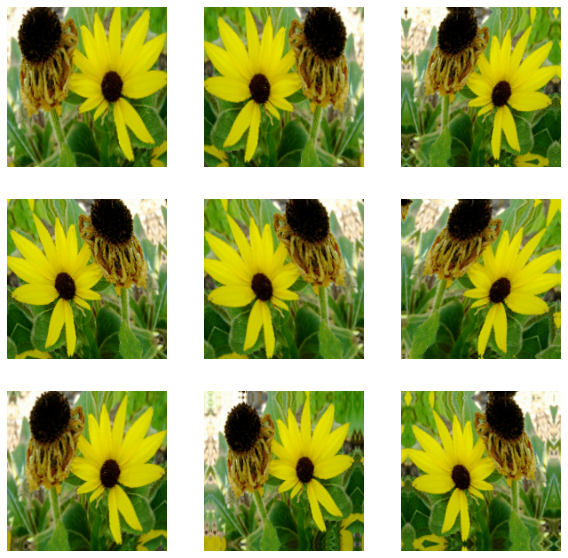

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#### 드롭아웃

pytorch의 dropout는 신경망을 정의할 때, dropout을 추가하여 정의하면 된다.  
tensorflow의 경우 Sequential 내에 dropout을 추가하여 사용하면 된다.

In [25]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### 모델 컴파일 및 훈련하기

pytorch의 경우 critertion, optimizer을 지정하여 손실함수와 최적화 기법을 지정한다.  
tensorflow의 경우 model.compile을 통하여 최적화기법과 손실함수, 평가척도를 지정할 있다.

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

pytorch의 경우 Net class를 변수로 지정하여 print를 통해 모델을 확인할 수 있다.  
tensorflow의 경우 model.summary()를 통해 모델을 확인할 수 있다.

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

pytorch는 반복문을 통하여 신경망을 학습한다.  
tensorflow의 경우는 model.fit()을 이용하여 학습을 진행할 수 있다.

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 41s 445ms/step - loss: 1.2988 - accuracy: 0.4196 - val_loss: 1.1891 - val_accuracy: 0.5272
Epoch 2/15
92/92 [==============================] - 37s 405ms/step - loss: 1.0354 - accuracy: 0.5909 - val_loss: 1.0434 - val_accuracy: 0.5722
Epoch 3/15
92/92 [==============================] - 46s 499ms/step - loss: 0.9228 - accuracy: 0.6359 - val_loss: 0.9458 - val_accuracy: 0.6390
Epoch 4/15
92/92 [==============================] - 46s 496ms/step - loss: 0.8795 - accuracy: 0.6614 - val_loss: 0.9116 - val_accuracy: 0.6390
Epoch 5/15
92/92 [==============================] - 38s 411ms/step - loss: 0.8119 - accuracy: 0.6894 - val_loss: 0.8386 - val_accuracy: 0.6594
Epoch 6/15
92/92 [==============================] - 37s 400ms/step - loss: 0.7760 - accuracy: 0.7064 - val_loss: 0.7773 - val_accuracy: 0.7003
Epoch 7/15
92/92 [==============================] - 36s 390ms/step - loss: 0.7219 - accuracy: 0.7187 - val_loss: 0.8744 - val_accuracy: 0.6649

#### 훈련 결과 시각화하기

pytorch의 경우는 별도로 변수를 설정하여 훈련 결과를 시각화 한다.  
tensorflow의 경우는 history 내의 변수를 이용하여 결과를 시각화 한다.

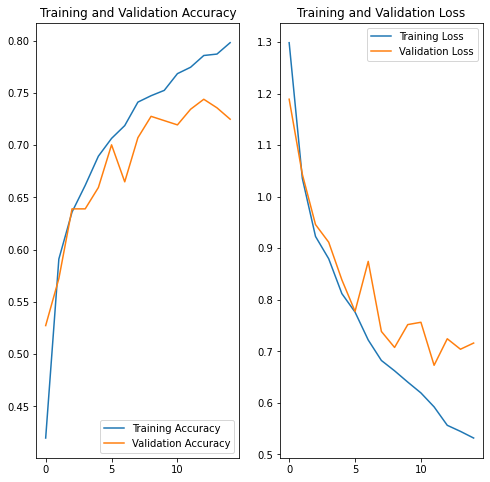

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 새로운 데이터로 예측하기

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 99.54 percent confidence.


### 5. 다음 링크의 제시된 와인 분류의 코드를 제시된 조건에 맞게 완성하세요. (7점)

https://colab.research.google.com/drive/1PawcTyechmYd_-DRGsIs9hLsnknpHPbC?usp=sharing

In [31]:
# Data loading

from sklearn.datasets import load_wine

dataset = load_wine()
data = dataset.data
labels = dataset.target

print(data)
print(labels)
print(data.shape)

[[1.423e+01 1.710e+00 2.430e+00 ... 1.040e+00 3.920e+00 1.065e+03]
 [1.320e+01 1.780e+00 2.140e+00 ... 1.050e+00 3.400e+00 1.050e+03]
 [1.316e+01 2.360e+00 2.670e+00 ... 1.030e+00 3.170e+00 1.185e+03]
 ...
 [1.327e+01 4.280e+00 2.260e+00 ... 5.900e-01 1.560e+00 8.350e+02]
 [1.317e+01 2.590e+00 2.370e+00 ... 6.000e-01 1.620e+00 8.400e+02]
 [1.413e+01 4.100e+00 2.740e+00 ... 6.100e-01 1.600e+00 5.600e+02]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
(178, 13)


In [32]:
# Split data

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3) 

print(len(x_train), len(x_test), type(x_train))

print(x_test)
print(y_test)

124 54 <class 'numpy.ndarray'>
[[1.316000e+01 2.360000e+00 2.670000e+00 1.860000e+01 1.010000e+02
  2.800000e+00 3.240000e+00 3.000000e-01 2.810000e+00 5.680000e+00
  1.030000e+00 3.170000e+00 1.185000e+03]
 [1.387000e+01 1.900000e+00 2.800000e+00 1.940000e+01 1.070000e+02
  2.950000e+00 2.970000e+00 3.700000e-01 1.760000e+00 4.500000e+00
  1.250000e+00 3.400000e+00 9.150000e+02]
 [1.410000e+01 2.160000e+00 2.300000e+00 1.800000e+01 1.050000e+02
  2.950000e+00 3.320000e+00 2.200000e-01 2.380000e+00 5.750000e+00
  1.250000e+00 3.170000e+00 1.510000e+03]
 [1.356000e+01 1.730000e+00 2.460000e+00 2.050000e+01 1.160000e+02
  2.960000e+00 2.780000e+00 2.000000e-01 2.450000e+00 6.250000e+00
  9.800000e-01 3.030000e+00 1.120000e+03]
 [1.299000e+01 1.670000e+00 2.600000e+00 3.000000e+01 1.390000e+02
  3.300000e+00 2.890000e+00 2.100000e-01 1.960000e+00 3.350000e+00
  1.310000e+00 3.500000e+00 9.850000e+02]
 [1.264000e+01 1.360000e+00 2.020000e+00 1.680000e+01 1.000000e+02
  2.020000e+00 1.41000

In [33]:
# Convert to tensor

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

print(type(x_train))

<class 'torch.Tensor'>


문제 1 : train_loader 생성 ( 1점 )  
조건 1 : train_set 변수 활용  
조건 2 : 배치 크기는 16  
조건 3 : shuffle 사용

In [34]:
# Generating dataset

train_set = TensorDataset(x_train, y_train)
test_set = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_set, batch_size = 16, shuffle=True)

문제 2 :  간단한 Linear 모델 구성 ( 2점 )  
조건 1 : 총 Layer 수는 6개이며, 입력부터 Feature 사이즈 진행은 다음과 같다.  
(입력 -> 256 -> 128 -> 64 -> 32 -> 16 -> 3)  
조건 2 : Layer1,2,3 직후에는 Batch Normalization 층이 존재한다.  
조건 3 : 활성함수는 ReLU를 사용한다.  
      
문제 3 : Linear 모델 forward 함수 작성 ( 1점 )  
조건 1 : 기본 순서는 다음과 같다.  
(Linear 층 - Batch Normalization - Activation)  
조건 2 : 마지막 Linear 후에는 Activation을 사용하지 않고, 문제 2에서 멤버변수로 선언한 Softmax 를 사용한다.
    

In [35]:
# Construct model

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer0 = nn.Linear(13, 256)
        self.layer1 = nn.Linear(256, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 16)
        self.layer5 = nn.Linear(16, 3)
        self.bn0 = nn.BatchNorm1d(256)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)

        self.act = nn.ReLU()
        # self.softmax = nn.Softmax(dim=1)  
        

    def forward(self,x):

        x = self.act(self.bn0(self.layer0(x)))
        x = self.act(self.bn1(self.layer1(x)))
        x = self.act(self.bn2(self.layer2(x)))
        x = self.act(self.layer3(x))
        x = self.act(self.layer4(x))
        x = self.layer5(x)
        # x = self.softmax(x)   
        
        return x

model = Model()
print(model)

Model(
  (layer0): Linear(in_features=13, out_features=256, bias=True)
  (layer1): Linear(in_features=256, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=32, bias=True)
  (layer4): Linear(in_features=32, out_features=16, bias=True)
  (layer5): Linear(in_features=16, out_features=3, bias=True)
  (bn0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
)


문제 4 : Optimizer 생성 (1점)  
조건 1 : SGD 생성  
조건 2 : 학습률 0.001  
조건 3 : Momentum 0.9  
  
문제 5 : 손실 함수 생성 (1점)  
조건 1 : Cross Entropy Loss 생성

In [36]:
# Configure optimizer

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

문제 6 : Training code 작성 (1점)  
조건 1 : 튜토리얼에서 학습했던 내용과 같이 학습 코드 작성

In [37]:
# Training

epochs = 200
losses = list()
accuracies = list()

for epoch in range(epochs):
    epoch_loss = 0  
    epoch_accuracy = 0


    for x, y in train_loader:

        optimizer.zero_grad()

        output = model(x)

        loss = criterion(output, y)
        loss.backward()

        optimizer.step()

        _, predicted = torch.max(output, dim=1)
        accuracy = (predicted == y).sum().item()
        epoch_loss += loss.item()
        epoch_accuracy += accuracy
  

    epoch_loss /= len(train_loader)
    epoch_accuracy /= len(x_train)
    print("epoch :{}, \tloss :{}, \taccuracy :{}".format(str(epoch+1).zfill(3),round(epoch_loss,4), round(epoch_accuracy,4)))

    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

epoch :001, 	loss :1.1136, 	accuracy :0.3226
epoch :002, 	loss :1.0982, 	accuracy :0.3226
epoch :003, 	loss :1.0852, 	accuracy :0.3226
epoch :004, 	loss :1.0728, 	accuracy :0.371
epoch :005, 	loss :1.0635, 	accuracy :0.3871
epoch :006, 	loss :1.0421, 	accuracy :0.4677
epoch :007, 	loss :1.0281, 	accuracy :0.5887
epoch :008, 	loss :1.0149, 	accuracy :0.621
epoch :009, 	loss :0.9867, 	accuracy :0.6774
epoch :010, 	loss :0.9678, 	accuracy :0.6774
epoch :011, 	loss :0.9555, 	accuracy :0.6855
epoch :012, 	loss :0.9258, 	accuracy :0.6855
epoch :013, 	loss :0.914, 	accuracy :0.6935
epoch :014, 	loss :0.9008, 	accuracy :0.7097
epoch :015, 	loss :0.8719, 	accuracy :0.6935
epoch :016, 	loss :0.8593, 	accuracy :0.6855
epoch :017, 	loss :0.83, 	accuracy :0.7016
epoch :018, 	loss :0.8089, 	accuracy :0.7097
epoch :019, 	loss :0.7886, 	accuracy :0.7258
epoch :020, 	loss :0.79, 	accuracy :0.7016
epoch :021, 	loss :0.7665, 	accuracy :0.6935
epoch :022, 	loss :0.7659, 	accuracy :0.6774
epoch :023, 	loss

epoch :187, 	loss :0.268, 	accuracy :0.9435
epoch :188, 	loss :0.3182, 	accuracy :0.879
epoch :189, 	loss :0.3386, 	accuracy :0.8871
epoch :190, 	loss :0.2895, 	accuracy :0.8871
epoch :191, 	loss :0.2926, 	accuracy :0.8871
epoch :192, 	loss :0.3433, 	accuracy :0.8952
epoch :193, 	loss :0.2513, 	accuracy :0.9113
epoch :194, 	loss :0.3038, 	accuracy :0.871
epoch :195, 	loss :0.2514, 	accuracy :0.8871
epoch :196, 	loss :0.273, 	accuracy :0.8871
epoch :197, 	loss :0.2283, 	accuracy :0.8952
epoch :198, 	loss :0.288, 	accuracy :0.871
epoch :199, 	loss :0.2681, 	accuracy :0.8952
epoch :200, 	loss :0.2395, 	accuracy :0.9032


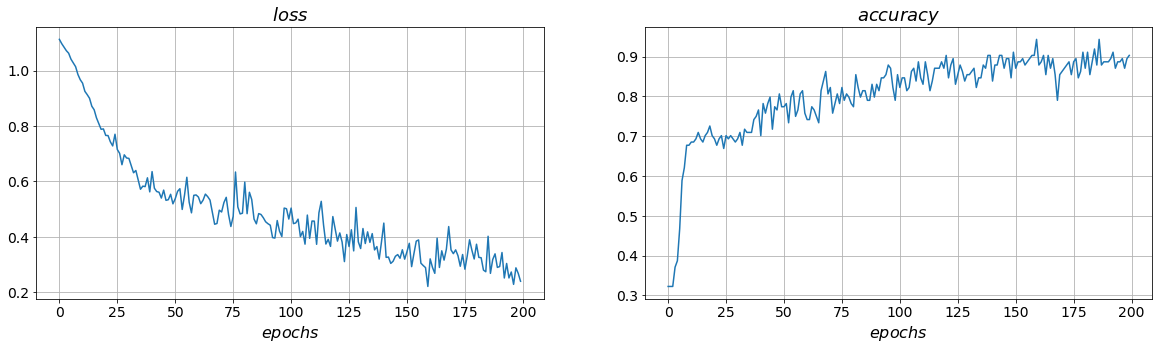

In [38]:
# Plot result

import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.2)

plt.subplot(1,2,1)
plt.title("$loss$",fontsize = 18)
plt.plot(losses)
plt.grid()
plt.xlabel("$epochs$", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)


plt.subplot(1,2,2)
plt.title("$accuracy$", fontsize = 18)
plt.plot(accuracies)
plt.grid()
plt.xlabel("$epochs$", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.show()

In [39]:
# Test

output = model(x_test)
_, predicted = torch.max(output, dim=1)
accuracy = round((predicted == y_test).sum().item() / len(y_test),4)


print("test_set accuracy :", round(accuracy,4))

test_set accuracy : 0.8889


### 6. PyTorch의 torchvision을 활용하여 ImageNet으로 사전학습된 AlexNet, VGG, ResNet, DenseNet의 성능을 ImageNet Validation dataset (2012) 기준으로 비교하세요. (7점)

AlexNet (가장 낮은 성능을 보인다.)  
- top-1 percentage :  56.52%  
- top-5 percentage :  79.07%  

VGG  
- top-1 percentage :  71.59%  
- top-5 percentage :  90.38%  
    
ResNet  
- top-1 percentage :  69.76%  
- top-5 percentage :  89.08%  
    
DenseNet (가장 높은 성능을 보인다.)  
- top-1 percentage :  77.14%  
- top-5 percentage :  93.56%

성능순서 : DenseNet >> VGG >> ResNet >> AlexNet

In [40]:
import torchvision.models as models
alexnet = models.alexnet(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
resnet18 = models.resnet18(pretrained=True)
densenet = models.densenet161(pretrained=True)

In [41]:
import os
import wget # pip install wget


def bar_custom(current, total, width=80):
    progress = "Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total)
    return progress


def download_imagenet(root='F:\data\example'):
    """
    download_imagenet validation set
    :param img_dir: root for download imagenet
    :return:
    """

    # make url
    val_url = 'http://www.image-net.org/challenges/LSVRC/2012/dd31405981ef5f776aa17412e1f0c112/ILSVRC2012_img_val.tar'
    devkit_url = 'http://www.image-net.org/challenges/LSVRC/2012/dd31405981ef5f776aa17412e1f0c112/ILSVRC2012_devkit_t12.tar.gz'
    # https://image-net.org/challenges/LSVRC/2012/2012-downloads.php
    print("Download...")
    os.makedirs(root, exist_ok=True)
    wget.download(url=val_url, out=root, bar=bar_custom)
    print('')
    wget.download(url=devkit_url, out=root, bar=bar_custom)
    print('')
    print('done!')

In [42]:
import torchvision

testset = torchvision.datasets.ImageNet(root="F:\data\example", split='val')

#### AlexNet

In [43]:
import torchvision.models as models

alexnet = models.alexnet(pretrained=True)

In [44]:
import torch
import torchvision
import torch.utils.data as data
import torchvision.transforms as transforms


if __name__ == "__main__":
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    transform = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         normalize,
         ])

    test_set = torchvision.datasets.ImageNet(root="F:\data\example", transform=transform, split='val')
    test_loader = data.DataLoader(test_set, batch_size=100, shuffle=True, num_workers=4)

    alexnet = torchvision.models.alexnet(pretrained=True).to(device)
    alexnet.eval()

    correct_top1 = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):

            images = images.to(device)      # [100, 3, 224, 224]
            labels = labels.to(device)      # [100]
            outputs = alexnet(images)

            # ------------------------------------------------------------------------------
            # rank 1
            _, pred = torch.max(outputs, 1)
            total += labels.size(0)
            correct_top1 += (pred == labels).sum().item()

            # ------------------------------------------------------------------------------
            # rank 5
            _, rank5 = outputs.topk(5, 1, True, True)
            rank5 = rank5.t()
            correct5 = rank5.eq(labels.reshape(1, -1).expand_as(rank5))

            # ------------------------------------------------------------------------------
            for k in range(6):
                correct_k = correct5[:k].reshape(-1).float().sum(0, keepdim=True)

            correct_top5 += correct_k.item()

            # print("step : {} / {}".format(idx + 1, len(test_set)/int(labels.size(0))))
            # print("top-1 percentage :  {0:0.2f}%".format(correct_top1 / total * 100))
            # print("top-5 percentage :  {0:0.2f}%".format(correct_top5 / total * 100))
            
    print("top-1 percentage :  {0:0.2f}%".format(correct_top1 / total * 100))
    print("top-5 percentage :  {0:0.2f}%".format(correct_top5 / total * 100))

top-1 percentage :  56.52%
top-5 percentage :  79.07%


#### VGG

In [45]:
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

In [46]:
import torch
import torchvision
import torch.utils.data as data
import torchvision.transforms as transforms


if __name__ == "__main__":
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    transform = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         normalize,
         ])

    test_set = torchvision.datasets.ImageNet(root="F:\data\example", transform=transform, split='val')
    test_loader = data.DataLoader(test_set, batch_size=100, shuffle=True, num_workers=4)

    vgg16 = torchvision.models.vgg16(pretrained=True).to(device)
    vgg16.eval()

    correct_top1 = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):

            images = images.to(device)      # [100, 3, 224, 224]
            labels = labels.to(device)      # [100]
            outputs = vgg16(images)

            # ------------------------------------------------------------------------------
            # rank 1
            _, pred = torch.max(outputs, 1)
            total += labels.size(0)
            correct_top1 += (pred == labels).sum().item()

            # ------------------------------------------------------------------------------
            # rank 5
            _, rank5 = outputs.topk(5, 1, True, True)
            rank5 = rank5.t()
            correct5 = rank5.eq(labels.reshape(1, -1).expand_as(rank5))

            # ------------------------------------------------------------------------------
            for k in range(6):
                correct_k = correct5[:k].reshape(-1).float().sum(0, keepdim=True)

            correct_top5 += correct_k.item()

            # print("step : {} / {}".format(idx + 1, len(test_set)/int(labels.size(0))))
            # print("top-1 percentage :  {0:0.2f}%".format(correct_top1 / total * 100))
            # print("top-5 percentage :  {0:0.2f}%".format(correct_top5 / total * 100))
            
    print("top-1 percentage :  {0:0.2f}%".format(correct_top1 / total * 100))
    print("top-5 percentage :  {0:0.2f}%".format(correct_top5 / total * 100))

top-1 percentage :  71.59%
top-5 percentage :  90.38%


#### ResNet

In [47]:
import torchvision.models as models

resnet18 = models.resnet18(pretrained=True)

In [48]:
import torch
import torchvision
import torch.utils.data as data
import torchvision.transforms as transforms


if __name__ == "__main__":
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    transform = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         normalize,
         ])

    test_set = torchvision.datasets.ImageNet(root="F:\data\example", transform=transform, split='val')
    test_loader = data.DataLoader(test_set, batch_size=100, shuffle=True, num_workers=4)

    resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
    resnet18.eval()

    correct_top1 = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):

            images = images.to(device)      # [100, 3, 224, 224]
            labels = labels.to(device)      # [100]
            outputs = resnet18(images)

            # ------------------------------------------------------------------------------
            # rank 1
            _, pred = torch.max(outputs, 1)
            total += labels.size(0)
            correct_top1 += (pred == labels).sum().item()

            # ------------------------------------------------------------------------------
            # rank 5
            _, rank5 = outputs.topk(5, 1, True, True)
            rank5 = rank5.t()
            correct5 = rank5.eq(labels.reshape(1, -1).expand_as(rank5))

            # ------------------------------------------------------------------------------
            for k in range(6):
                correct_k = correct5[:k].reshape(-1).float().sum(0, keepdim=True)

            correct_top5 += correct_k.item()

            # print("step : {} / {}".format(idx + 1, len(test_set)/int(labels.size(0))))
            # print("top-1 percentage :  {0:0.2f}%".format(correct_top1 / total * 100))
            # print("top-5 percentage :  {0:0.2f}%".format(correct_top5 / total * 100))
            
    print("top-1 percentage :  {0:0.2f}%".format(correct_top1 / total * 100))
    print("top-5 percentage :  {0:0.2f}%".format(correct_top5 / total * 100))

top-1 percentage :  69.76%
top-5 percentage :  89.08%


#### DenseNet

In [49]:
import torchvision.models as models

densenet = models.densenet161(pretrained=True)

In [50]:
import torch
import torchvision
import torch.utils.data as data
import torchvision.transforms as transforms


if __name__ == "__main__":
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    transform = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         normalize,
         ])

    test_set = torchvision.datasets.ImageNet(root="F:\data\example", transform=transform, split='val')
    test_loader = data.DataLoader(test_set, batch_size=100, shuffle=True, num_workers=4)

    densenet = torchvision.models.densenet161(pretrained=True).to(device)
    densenet.eval()

    correct_top1 = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):

            images = images.to(device)      # [100, 3, 224, 224]
            labels = labels.to(device)      # [100]
            outputs = densenet(images)

            # ------------------------------------------------------------------------------
            # rank 1
            _, pred = torch.max(outputs, 1)
            total += labels.size(0)
            correct_top1 += (pred == labels).sum().item()

            # ------------------------------------------------------------------------------
            # rank 5
            _, rank5 = outputs.topk(5, 1, True, True)
            rank5 = rank5.t()
            correct5 = rank5.eq(labels.reshape(1, -1).expand_as(rank5))

            # ------------------------------------------------------------------------------
            for k in range(6):
                correct_k = correct5[:k].reshape(-1).float().sum(0, keepdim=True)

            correct_top5 += correct_k.item()

            # print("step : {} / {}".format(idx + 1, len(test_set)/int(labels.size(0))))
            # print("top-1 percentage :  {0:0.2f}%".format(correct_top1 / total * 100))
            # print("top-5 percentage :  {0:0.2f}%".format(correct_top5 / total * 100))
            
    print("top-1 percentage :  {0:0.2f}%".format(correct_top1 / total * 100))
    print("top-5 percentage :  {0:0.2f}%".format(correct_top5 / total * 100))

top-1 percentage :  77.14%
top-5 percentage :  93.56%


### 7. 다음 조건을 만족하는 컨볼루션 신경망을 구현하고, 3번의 (3), (6), (7)의 성능 결과를 확인하고 비교하세요. (21점)

(1) INPUT-CONV(32 33)-CONV(32 33)-RELU-POOL-CONV(32 33)- CONV(32 33)-RELU-POOL-FC-OUTPUT 구조의 CNN을 작성하고 동일한 학습 과정 수행  
- Accuracy of the network on the 10000 test images: 61 %  

(2) 3번 문제의 신경망에 Adam 최적화 (강의자료의 기본 hyper-parameters 사용) 적용  
- Accuracy of the network on the 10000 test images: 59 %  

(3) 데이터 확대 방법들 중 하나를 적용한 후, 3번 문제의 신경망 학습 (Hint: transforms)  
- Accuracy of the network on the 10000 test images: 62 % (가장 높은 성능을 보인다.)  

(4) 3번 문제의 신경망에 배치 정규화를 적용 (Hint: nn.BatchNorm)  
- Accuracy of the network on the 10000 test images: 53 % (CIFAR10 데이터 중에 가장 낮은 성능을 보인다.)  

(5) 3번 문제의 신경망에 로그우도 (-log) 손실함수를 적용  
- Accuracy of the network on the 10000 test images: 59 %  

(6) 3번 문제의 신경망에 L2놈 규제 적용  
- Accuracy of the network on the 10000 test images: 61 %  

(7) 5번 문제에서 사용한 꽃 사진 데이터를 3번 문제의 신경망에 적용  
- Accuracy of the network on the 1000 test images: 52 % (가장 낮은 성능을 보인다.)  

데이터 증강을 이용한 (3)의 성능이 62%로 가장 높았고, 그 다음으로 L2 규제를 적용한 (6)의 성능이 61%로 나타났으며, 5번 문제에서 사용한 꽃 사진 데이터를 3번 신경망에 적용했을 때, 성능이 52%로 가장 낮았다.

In [1]:
### 정규화된 CIFAR-10 훈련집합과 테스트집합을 torchvision을 이용하여 적재함

import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### (1) INPUT-CONV(32 3*3)-CONV(32 3*3)-RELU-POOL-CONV(32 3*3)- CONV(32 3*3)-RELU-POOL-FC-OUTPUT 구조의 CNN을 작성하고 동일한 학습 과정 수행

In [2]:
### 컨볼루션 신경망을 정의함

# 3채널 32*32 크기의 사진을 입력받고, 신경망을 통과해 10 부류를 수행
import torch.nn as nn
import torch.nn.functional as F

class Net7(nn.Module):
    def __init__(self):
        super(Net7, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(self.relu(self.conv2(self.conv1(x))))
        x = self.pool(self.relu(self.conv2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net7 = Net7()
print(net7)

Net7(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [3]:
### 손실함수 정의, 교차 엔트로피와 SGD+momentum

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net7.parameters(), lr=0.001, momentum=0.9)

### 훈련집합을 이용하여 신경망을 학습시킴

for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net7(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999: # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
            
print('Finished Training')

[1,  1000] loss: 2.301
[1,  2000] loss: 2.195
[1,  3000] loss: 1.977
[1,  4000] loss: 1.838
[1,  5000] loss: 1.672
[1,  6000] loss: 1.619
[1,  7000] loss: 1.517
[1,  8000] loss: 1.513
[1,  9000] loss: 1.445
[1, 10000] loss: 1.452
[1, 11000] loss: 1.392
[1, 12000] loss: 1.346
[2,  1000] loss: 1.312
[2,  2000] loss: 1.283
[2,  3000] loss: 1.259
[2,  4000] loss: 1.244
[2,  5000] loss: 1.238
[2,  6000] loss: 1.221
[2,  7000] loss: 1.211
[2,  8000] loss: 1.169
[2,  9000] loss: 1.190
[2, 10000] loss: 1.169
[2, 11000] loss: 1.124
[2, 12000] loss: 1.142
Finished Training


In [4]:
# performance on the whole test dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net7(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 61 %


In [5]:
# performance on each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net7(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 57 %
Accuracy of   car : 75 %
Accuracy of  bird : 55 %
Accuracy of   cat : 50 %
Accuracy of  deer : 58 %
Accuracy of   dog : 42 %
Accuracy of  frog : 59 %
Accuracy of horse : 70 %
Accuracy of  ship : 76 %
Accuracy of truck : 69 %


#### (2) 3번 문제의 신경망에 Adam 최적화 (강의자료의 기본 hyper-parameters 사용) 적용

In [6]:
### 컨볼루션 신경망을 정의함

# 3채널 32*32 크기의 사진을 입력받고, 신경망을 통과해 10 부류를 수행
import torch.nn as nn
import torch.nn.functional as F

class Net7(nn.Module):
    def __init__(self):
        super(Net7, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(self.relu(self.conv2(self.conv1(x))))
        x = self.pool(self.relu(self.conv2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net7 = Net7()
print(net7)

Net7(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [7]:
### 손실함수 정의, 교차 엔트로피와 Adam

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net7.parameters(), lr = 0.001)

### 훈련집합을 이용하여 신경망을 학습시킴

for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net7(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999: # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
            
print('Finished Training')

[1,  1000] loss: 2.043
[1,  2000] loss: 1.748
[1,  3000] loss: 1.633
[1,  4000] loss: 1.574
[1,  5000] loss: 1.458
[1,  6000] loss: 1.407
[1,  7000] loss: 1.356
[1,  8000] loss: 1.323
[1,  9000] loss: 1.344
[1, 10000] loss: 1.285
[1, 11000] loss: 1.292
[1, 12000] loss: 1.272
[2,  1000] loss: 1.208
[2,  2000] loss: 1.205
[2,  3000] loss: 1.203
[2,  4000] loss: 1.151
[2,  5000] loss: 1.187
[2,  6000] loss: 1.173
[2,  7000] loss: 1.156
[2,  8000] loss: 1.141
[2,  9000] loss: 1.132
[2, 10000] loss: 1.131
[2, 11000] loss: 1.174
[2, 12000] loss: 1.133
Finished Training


In [8]:
# performance on the whole test dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net7(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


In [9]:
# performance on each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net7(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 54 %
Accuracy of   car : 69 %
Accuracy of  bird : 33 %
Accuracy of   cat : 51 %
Accuracy of  deer : 72 %
Accuracy of   dog : 32 %
Accuracy of  frog : 83 %
Accuracy of horse : 47 %
Accuracy of  ship : 74 %
Accuracy of truck : 72 %


#### (3) 데이터 확대 방법들 중 하나를 적용한 후, 3번 문제의 신경망 학습 (Hint: transforms)

RandomHorizontalFlip()을 적용하였다

In [10]:
### 정규화된 CIFAR-10 훈련집합과 테스트집합을 torchvision을 이용하여 적재함

import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.RandomHorizontalFlip(), 
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [11]:
### 컨볼루션 신경망을 정의함

# 3채널 32*32 크기의 사진을 입력받고, 신경망을 통과해 10 부류를 수행
import torch.nn as nn
import torch.nn.functional as F

class Net7(nn.Module):
    def __init__(self):
        super(Net7, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(self.relu(self.conv2(self.conv1(x))))
        x = self.pool(self.relu(self.conv2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net7 = Net7()
print(net7)

Net7(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [12]:
### 손실함수 정의, 교차 엔트로피와 SGD + Momentum

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net7.parameters(), lr=0.001, momentum=0.9)

### 훈련집합을 이용하여 신경망을 학습시킴

for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net7(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999: # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
            
print('Finished Training')

[1,  1000] loss: 2.300
[1,  2000] loss: 2.126
[1,  3000] loss: 1.946
[1,  4000] loss: 1.808
[1,  5000] loss: 1.730
[1,  6000] loss: 1.633
[1,  7000] loss: 1.571
[1,  8000] loss: 1.515
[1,  9000] loss: 1.490
[1, 10000] loss: 1.451
[1, 11000] loss: 1.401
[1, 12000] loss: 1.380
[2,  1000] loss: 1.346
[2,  2000] loss: 1.324
[2,  3000] loss: 1.266
[2,  4000] loss: 1.266
[2,  5000] loss: 1.207
[2,  6000] loss: 1.246
[2,  7000] loss: 1.164
[2,  8000] loss: 1.145
[2,  9000] loss: 1.157
[2, 10000] loss: 1.152
[2, 11000] loss: 1.138
[2, 12000] loss: 1.108
Finished Training


In [13]:
# performance on the whole test dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net7(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 62 %


In [14]:
# performance on each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net7(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 60 %
Accuracy of   car : 79 %
Accuracy of  bird : 37 %
Accuracy of   cat : 42 %
Accuracy of  deer : 49 %
Accuracy of   dog : 71 %
Accuracy of  frog : 82 %
Accuracy of horse : 51 %
Accuracy of  ship : 77 %
Accuracy of truck : 72 %


#### (4) 3번 문제의 신경망에 배치 정규화를 적용 (Hint: nn.BatchNorm)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net7(nn.Module):
    def __init__(self):
        super(Net7, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net7 = Net7()
print(net7)

Net7(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [16]:
### 손실함수 정의, 교차 엔트로피와 SGD + Momentum

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net7.parameters(), lr=0.001, momentum=0.9)

### 훈련집합을 이용하여 신경망을 학습시킴

for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net7(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999: # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
            
print('Finished Training')

[1,  1000] loss: 2.092
[1,  2000] loss: 1.828
[1,  3000] loss: 1.712
[1,  4000] loss: 1.642
[1,  5000] loss: 1.620
[1,  6000] loss: 1.603
[1,  7000] loss: 1.562
[1,  8000] loss: 1.522
[1,  9000] loss: 1.525
[1, 10000] loss: 1.487
[1, 11000] loss: 1.505
[1, 12000] loss: 1.478
[2,  1000] loss: 1.418
[2,  2000] loss: 1.400
[2,  3000] loss: 1.401
[2,  4000] loss: 1.384
[2,  5000] loss: 1.338
[2,  6000] loss: 1.356
[2,  7000] loss: 1.346
[2,  8000] loss: 1.339
[2,  9000] loss: 1.360
[2, 10000] loss: 1.330
[2, 11000] loss: 1.335
[2, 12000] loss: 1.286
Finished Training


In [17]:
# performance on the whole test dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net7(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [18]:
# performance on each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net7(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 60 %
Accuracy of   car : 58 %
Accuracy of  bird : 23 %
Accuracy of   cat : 37 %
Accuracy of  deer : 51 %
Accuracy of   dog : 51 %
Accuracy of  frog : 56 %
Accuracy of horse : 66 %
Accuracy of  ship : 65 %
Accuracy of truck : 62 %


#### (5) 3번 문제의 신경망에 로그우도 (-log) 손실함수를 적용

In [19]:
### 손실함수 정의, 로그우도와 Adam

import torch.optim as optim

criterion = nn.NLLLoss()
optimizer = optim.Adam(net7.parameters(), lr = 0.001)
m = nn.LogSoftmax()

### 훈련집합을 이용하여 신경망을 학습시킴

for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net7(inputs)
        loss = criterion(m(outputs), labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999: # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
            
print('Finished Training')

<ipython-input-19-1dac2c140265>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = criterion(m(outputs), labels)


[1,  1000] loss: 1.399
[1,  2000] loss: 1.350
[1,  3000] loss: 1.339
[1,  4000] loss: 1.361
[1,  5000] loss: 1.322
[1,  6000] loss: 1.342
[1,  7000] loss: 1.298
[1,  8000] loss: 1.304
[1,  9000] loss: 1.291
[1, 10000] loss: 1.265
[1, 11000] loss: 1.286
[1, 12000] loss: 1.263
[2,  1000] loss: 1.220
[2,  2000] loss: 1.210
[2,  3000] loss: 1.218
[2,  4000] loss: 1.192
[2,  5000] loss: 1.201
[2,  6000] loss: 1.181
[2,  7000] loss: 1.191
[2,  8000] loss: 1.211
[2,  9000] loss: 1.221
[2, 10000] loss: 1.188
[2, 11000] loss: 1.194
[2, 12000] loss: 1.191
Finished Training


In [20]:
# performance on the whole test dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net7(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


In [21]:
# performance on each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net7(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 63 %
Accuracy of   car : 72 %
Accuracy of  bird : 38 %
Accuracy of   cat : 47 %
Accuracy of  deer : 47 %
Accuracy of   dog : 38 %
Accuracy of  frog : 69 %
Accuracy of horse : 62 %
Accuracy of  ship : 77 %
Accuracy of truck : 72 %


#### (6) 3번 문제의 신경망에 L2놈 규제 적용

weight_decay를 통해 L2규제를 적용

In [22]:
### 손실함수 정의, 교차 엔트로피와 Adam + L2 규제

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net7.parameters(), lr = 0.001, weight_decay=1e-5)

### 4. 훈련집합을 이용하여 신경망을 학습시킴

for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net7(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999: # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
            
print('Finished Training')

[1,  1000] loss: 1.114
[1,  2000] loss: 1.164
[1,  3000] loss: 1.142
[1,  4000] loss: 1.138
[1,  5000] loss: 1.158
[1,  6000] loss: 1.160
[1,  7000] loss: 1.136
[1,  8000] loss: 1.134
[1,  9000] loss: 1.118
[1, 10000] loss: 1.126
[1, 11000] loss: 1.118
[1, 12000] loss: 1.146
[2,  1000] loss: 1.067
[2,  2000] loss: 1.118
[2,  3000] loss: 1.108
[2,  4000] loss: 1.095
[2,  5000] loss: 1.075
[2,  6000] loss: 1.103
[2,  7000] loss: 1.103
[2,  8000] loss: 1.081
[2,  9000] loss: 1.066
[2, 10000] loss: 1.081
[2, 11000] loss: 1.112
[2, 12000] loss: 1.093
Finished Training


In [23]:
# performance on the whole test dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net7(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 61 %


In [24]:
# performance on each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net7(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 73 %
Accuracy of   car : 74 %
Accuracy of  bird : 44 %
Accuracy of   cat : 45 %
Accuracy of  deer : 53 %
Accuracy of   dog : 56 %
Accuracy of  frog : 62 %
Accuracy of horse : 66 %
Accuracy of  ship : 69 %
Accuracy of truck : 65 %


#### (7) 4번 문제에서 사용한 꽃 사진 데이터를 3번 문제의 신경망에 적용

In [26]:
import tensorflow as tf
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [27]:
transform_flower = torchvision.transforms.Compose(
    [  # Applying Augmentation
        torchvision.transforms.Resize((32,32)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(30),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)

In [28]:
dataset = torchvision.datasets.ImageFolder(data_dir, transform=transform_flower)

In [29]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [30]:
dataset_size = len(dataset)
dataset_size

3670

In [31]:
classes = dataset.classes
classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [32]:
random_seed = 42
torch.manual_seed(random_seed);

In [33]:
val_size = 1000
train_size = len(dataset) - val_size

train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(2670, 1000)

In [34]:
for cls in range(len(classes)):
    count = 0
    for _,label in dataset:
        if label == cls:
            count += 1

    print("{}. Number of images belonging to {} is {}".format(cls + 1, classes[cls], count))
    
    

1. Number of images belonging to daisy is 633
2. Number of images belonging to dandelion is 898
3. Number of images belonging to roses is 641
4. Number of images belonging to sunflowers is 699
5. Number of images belonging to tulips is 799


In [35]:
train_dl = torch.utils.data.dataloader.DataLoader(train_ds, batch_size = 4, 
                                                  shuffle=True, num_workers=2)
val_dl = torch.utils.data.dataloader.DataLoader(val_ds, batch_size = 4, 
                                                shuffle = False, num_workers=2)

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net7(nn.Module):
    def __init__(self):
        super(Net7, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net7 = Net7()
print(net7)

Net7(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [37]:
### 손실함수 정의, 교차 엔트로피와 Adam + L2 규제

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net7.parameters(), lr = 0.001, weight_decay=1e-5)

### 4. 훈련집합을 이용하여 신경망을 학습시킴

for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net7(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99: # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
            
print('Finished Training')

[1,   100] loss: 0.160
[1,   200] loss: 0.148
[1,   300] loss: 0.138
[1,   400] loss: 0.132
[1,   500] loss: 0.137
[1,   600] loss: 0.140
[2,   100] loss: 0.128
[2,   200] loss: 0.131
[2,   300] loss: 0.125
[2,   400] loss: 0.126
[2,   500] loss: 0.128
[2,   600] loss: 0.123
Finished Training


In [38]:
# performance on the whole test dataset
correct = 0
total = 0
with torch.no_grad():
    for data in val_dl:
        images, labels = data
        outputs = net7(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 1000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 1000 test images: 52 %


In [39]:
# performance on each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in val_dl:
        images, labels = data
        outputs = net7(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(5):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of daisy : 49 %
Accuracy of dandelion : 71 %
Accuracy of roses : 40 %
Accuracy of sunflowers : 60 %
Accuracy of tulips : 33 %


### 8. [MLP] 다음은 은닉층이 3개인 MLP입니다. (12점)

In [1]:
import torch
import torch.nn as nn

#### (1) 가중치 행렬 U1, U2, U3, U4를 쓰세요.

In [2]:
U1 = torch.tensor([[-0.3, 1.0, 1.2],
                   [1.6, -1.0, -1.1]])
U2 = torch.tensor([[1.0, 1.0, -1.0],
                   [0.7, 0.5, 1.0]])
U3 = torch.tensor([[0.5, -0.8, 1.0],
                   [-0.1, 0.3, 0.4]])
U4 = torch.tensor([[1.0, 0.1, -0.2],
                   [-0.2, 1.3, -0.4]])

#### (2) x=(1,0)T가 입력되었을 때 출력 o=(o1,o2)T를 구하세요. 활성함수는 로지스틱 시그모이드를 사용하세요.

#### (3) x=(1,0)T가 입력되었을 때 출력 o=(o1,o2)T를 구하세요. 활성함수는 ReLU를 사용하세요.

In [4]:
relu = nn.ReLU()

X = torch.tensor([[1.0, 1.0, 0.0]])
X_input = torch.tensor([[1.0]])

h_1 = X.mm(U1.T)
h_1 = relu(h_1)
h_1 = torch.cat((X_input, h_1), dim=1)

h_2 = h_1.mm(U2.T)
h_2 = relu(h_2)
h_2 = torch.cat((X_input, h_2), dim=1)

h_3 = h_2.mm(U3.T)
h_3 = relu(h_3)
h_3 = torch.cat((X_input, h_3), dim=1)

output = h_3.mm(U4.T)
output = relu(output)

result_relu = output

print(result_relu)

tensor([[0.9490, 1.0950]])


#### (4) x=(1,0)T의 기대 출력이 o=(0,1)일 때, 현재 1.0인 u312 가중치를 0.9로 줄이면 오류에 어떤 영향을 미치는지 설명하세요.

가중치를 갱신했을 때, 오류가 감소했음을 확인할 수 있다.

In [5]:
criterion = nn.MSELoss()
label = torch.tensor([[0.0, 1.0]])
loss = criterion(result_relu, label)
print('Previous loss: ', loss)

U3 = torch.tensor([[0.5, -0.8, 0.9],
                   [-0.1, 0.3, 0.4]])

relu = nn.ReLU()

X = torch.tensor([[1.0, 1.0, 0.0]])
X_input = torch.tensor([[1.0]])

h_1 = X.mm(U1.T)
h_1 = relu(h_1)
h_1 = torch.cat((X_input, h_1), dim=1)

h_2 = h_1.mm(U2.T)
h_2 = relu(h_2)
h_2 = torch.cat((X_input, h_2), dim=1)

h_3 = h_2.mm(U3.T)
h_3 = relu(h_3)
h_3 = torch.cat((X_input, h_3), dim=1)

output = h_3.mm(U4.T)
output = relu(output)

loss = criterion(output, label)

print('Current loss: ', loss)

Previous loss:  tensor(0.4548)
Current loss:  tensor(0.4419)


### 9. 컨볼루션 층의 입력 크기가 32 * 32 * 3이고, (a) 10개 5*5필터들을 보폭 1과 덧대기 2로 적용하였을 때 출력의 크기와 매개변수의 수를 구하세요. (b) 동일한 입력에 64개 3*3필터들을 보폭 1과 덧대기 1로 적용하였을 때 출력의 크기와 매개변수의 수도 구하세요. (10점)

#### 9-(a) 10개 5*5필터들을 보폭 1과 덧대기 2로 적용하였을 때 출력의 크기와 매개변수의 수를 구하세요.

In [45]:
# 입력 크기가 32*32*3이고 10개의 5*5 필터들을 보폭 1과 덧대기 2로
# 적용하였을 때의 출력 크기와 매개변수의 수

import torch
import torch.nn as nn
import torch.nn.functional as F

class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5, padding = 2)
    def forward(self, x):
        x = self.conv1(x)
        return x
    
net1 = Net1()
print(net1)

input = torch.randn(1, 3, 32, 32)
output = net1(input)
print(output.size())

print("전체 매개변수의 개수는", ((5 * 5 * 3) * 10) + 10, "개 입니다.")

Net1(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)
torch.Size([1, 10, 32, 32])
전체 매개변수의 개수는 760 개 입니다.


#### 9-(b) 동일한 입력에 64개 3*3필터들을 보폭 1과 덧대기 1로 적용하였을 때 출력의 크기와 매개변수의 수도 구하세요

In [46]:
# 동일한 입력에 64개 3*3필터들을 보폭 1과 덧대기 1로 적용하였을 때
# 출력의 크기와 매개변수의 수

import torch
import torch.nn as nn
import torch.nn.functional as F

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, padding = 1)
    def forward(self, x):
        x = self.conv1(x)
        return x
    
net2 = Net2()
print(net2)

input = torch.randn(1, 3, 32, 32)
output = net2(input)
print(output.size())

print("전체 매개변수의 개수는", ((3 * 3 * 3) * 64) + 64, "개 입니다.")

Net2(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
torch.Size([1, 64, 32, 32])
전체 매개변수의 개수는 1792 개 입니다.


### 10. 신경망의 출력이 (0.4, 2.0, 0.001, 0.32)T일 때 소프트맥스 함수를 적용한 결과를 쓰시오. (6점)

In [47]:
output = torch.tensor([[0.4, 2.0, 0.001, 0.32]])

F.softmax(output)

<ipython-input-47-42c8de2c6d93>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(output)


tensor([[0.1325, 0.6563, 0.0889, 0.1223]])

### 11. 소프트맥스 함수를 적용한 후 출력이 (0.001, 0.9, 0.001, 0.098)T이고 레이블 정보가 (0, 0, 0, 1)T일 때, 세 가지 목적함수, 평균제곱 오차, 교차 엔트로피, 로그우도를 수식적으로 계산하시오. (9점)

In [1]:
def mse_loss(output, target):
    return ((target-output)**2).mean()

def cross_entropy_loss(output, target):
    return -(target*torch.log(output)+(1-target)*torch.log(1-output)).sum()

def NLL_loss(output, target):
    return -(target*torch.log(output)).sum()

In [2]:
import torch
import torch.nn as nn

output = torch.tensor([[0.001, 0.9, 0.001, 0.098]])
target = torch.tensor([0, 0, 0, 1])
label = torch.tensor([3])

print('shape of output', output.shape)
print('shape of label', label.shape)

criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
criterion3 = nn.NLLLoss()

# MSELoss를 사용한 오차크기
loss1 = criterion1(output, target)
print('MSE loss', loss1.item())

# CrossEntropyLoss를 사용한 오차크기
import math
loss2 = -1 * (math.log(0.098)) # output[0][target.argmax().item()].item()
print('Cross entropy loss', loss2)

# NLLLoss를 사용한 오차크기
loss3 = criterion3(torch.log(output), label)
print('NLL loss', loss3.item())

shape of output torch.Size([1, 4])
shape of label torch.Size([1])
MSE loss 0.4059014916419983
Cross entropy loss 2.322787800311565
NLL loss 2.3227877616882324


C:\Users\zyunhyeok\anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
